In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [40]:
data = pd.read_csv('https://raw.githubusercontent.com/Viroslav/SFE/master/DS/dengue_features_train.csv', index_col=[0,1,2]) 
labels = pd.read_csv('https://raw.githubusercontent.com/Viroslav/SFE/master/DS/dengue_labels_train.csv', index_col=[0,1,2])
data = data.join(labels)


time = pd.to_datetime(data.loc['sj']['week_start_date'])
time = time.reset_index().week_start_date.tolist()


data.fillna(data.median(), inplace=True)


data.drop('week_start_date', axis=1, inplace=True)
data_sj, data_iq = data.loc['sj'], data.loc['iq']

In [41]:
def get_model(data, classifier):
  X, y = data.drop('total_cases', axis=1), data['total_cases']

  classifier.fit(X,y)
  return classifier

Handling NaN

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    n_estimators=1000,
    nthread=4,
    seed=42
)



parameters = {
    'max_depth': range (2, 10, 1),
    'learning_rate': [0.1, 0.01, 0.05]
}


grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose=4
)

In [16]:
X = X.reset_index().drop(columns=['weekofyear', 'year'], axis = 0)

In [42]:
import xgboost as xgb


clf = xgb.XGBClassifier(
    objective= 'binary:logistic',
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.01,
    nthread=4,
    seed=42,
    verbosity=2
)




clf_sj, clf_iq = get_model(data_sj, clf), get_model(data_iq, clf)

Streaming output truncated to the last 5000 lines.
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:48:19] INFO: /workspace/src/tree/updater_prune.cc

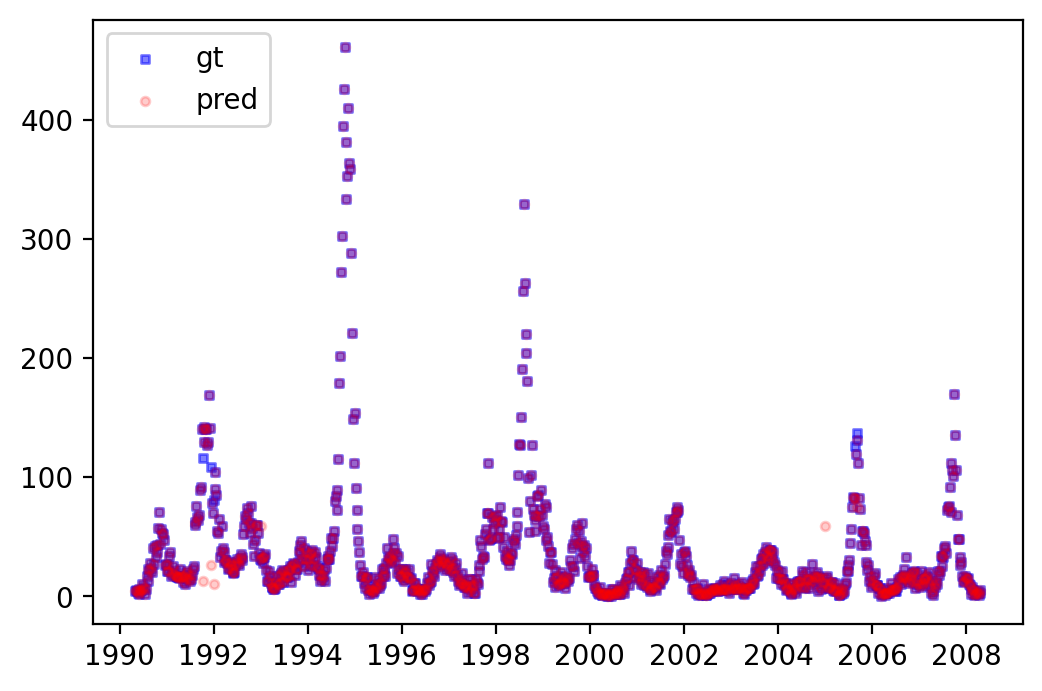

In [39]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(111)

ax1.scatter(time, y, alpha=0.5, s=10, c='b', marker="s", label='gt')
ax1.scatter(time, pred, alpha=0.2, s=10, c='r', marker="o", label='pred')
plt.legend(loc='upper left')
plt.show()

In [93]:
test = pd.read_csv('https://raw.githubusercontent.com/Viroslav/SFE/master/DS/dengue_features_train.csv',  index_col=[0, 1, 2])

time_test = pd.to_datetime(test.loc['sj']['week_start_date'])
time_test = time_test.reset_index().week_start_date.tolist()


test.fillna(test.median(), inplace=True)


test.drop('week_start_date', axis=1, inplace=True)
test_sj, test_iq = test.loc['sj'], test.loc['iq']

sj_predictions = clf_sj.predict(test_sj).astype(int)
iq_predictions = clf_iq.predict(test_iq).astype(int)

test.reset_index(inplace=True)
test['total_cases'] = np.concatenate([sj_predictions, iq_predictions], axis=0)
pd.DataFrame(test).to_csv("benchmark.csv", index=False)

In [101]:
x = pd.read_csv('/content/benchmark.csv', index_col=[0, 1, 2])

In [108]:
x[['total_cases']]

total_cases
city year weekofyear             
sj   1990 18                    0
          19                    1
          20                    9
          21                    2
          22                    7
...                           ...
iq   2010 21                    5
          22                    8
          23                    1
          24                    1
          25                    4

[1456 rows x 1 columns]

In [114]:
x[['total_cases']].reset_index().to_csv('submit.csv', index=False)

In [115]:
x = pd.read_csv('/content/submit.csv')

In [117]:
x.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,0
1,sj,1990,19,1
2,sj,1990,20,9
3,sj,1990,21,2
4,sj,1990,22,7
